# etPCAtest: Bootstrap calculation of standard error and
confidence interval for PCA results

RTB adapted for final exam, 11 October 2017, EB translated to Python 15 October 2021

What to do: Login to learning catalytics and join the session for the
module entitled "Last Class". You will answer a series of questions based
on the guided programming below. Each section begins with a '%%'. Read
through the comments and follow the instructions provided. In some cases
you will be asked to answer a question, clearly indicated by 'QUESTION'.
In other cases, you be asked to supply missing code, indicated by 'TODO'.
The corresponding question in learning catalytics will be indicated in
parentheses (e.g. Q1).  Note that the first section
doesn't require you to enter any code, so you can just execute this and
look at the plot. But make sure you read through the comments so that you
understand the data.

The data here are students' scores on tests in different subjects
from Mardia, Kent and Bilby (1979)
n = 88 students (rows) each took 5 tests (columns), in: 
Mechanics, Vectors, Algebra, Analysis and Statistics. 
The first two tests were closed book, the last three open book.

Principal components analysis (PCA) is a useful tool in multivariate
analysis, as we often have several variables that are correlated with one
another. PCA allows us to reduce the dimensions of our data by
transforming our data into orthogonal 'principal components' which
are uncorrelated and contain the information of the original dataset
(but may be difficult to interpret). The principal components, 
or eigenvectors if you've taken linear algebra, are linear combinations 
of the original variables of the dataset weighted by their contribution 
to explaining the data's variance in a particular orthogonal dimension,
chosen such that the first PC explains the most variance possible, the
second the next most possible in an orthogonal direction to the first,
and so on.

Original source of exercise: Efron, B. & Tibshirani Robert, J. (1993) 
An introduction to the bootstrap. Chapman & Hall, London u.a. pp. 61-70 
Adapted by RTB 5/31/2002, originally named bs_ex2.m
Developed for homework by RAS and RTB, August 2017

Concepts covered:
1. z-scoring to see relationships among different measures
2. PCA to capture maximal variance ('scientific IQ')
3. bootstrap to estimate std. error of our PCA-based statistic
4. bootstrap for confidence intervals by the percentile method


In [1]:
# Imports
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats 
import statsmodels.stats
import sklearn.decomposition

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [2]:
# Parmeters for bootstrap iterations and significance level. Don't change
# these!
n_boot = 5000
my_alpha = 0.05
test_names = ['Mechanics', 'Vectors', 'Algebra', 'Analysis', 'Statistics']

# Download google file
!gdown --id 1sdINHI_Zq0tKcNtGyJnhinky5GAq02L-

# Load data
ds = sio.loadmat('/content/MardiaTestScores.mat')

# Making the data shape (n,) instead of shape (n, 1) for pd dataframe
data = pd.DataFrame()
for key in test_names:
  data[key] = ds[key].reshape((-1,))

n_students, n_tests = data.shape

data.head()

Downloading...
From: https://drive.google.com/uc?id=1sdINHI_Zq0tKcNtGyJnhinky5GAq02L-
To: /content/MardiaTestScores.mat
100% 964/964 [00:00<00:00, 1.53MB/s]


Mechanics  Vectors  Algebra  Analysis  Statistics
0         77       82       67        67          81
1         63       78       80        70          81
2         75       73       71        66          81
3         55       72       63        70          68
4         63       63       65        70          63

# Make some plots

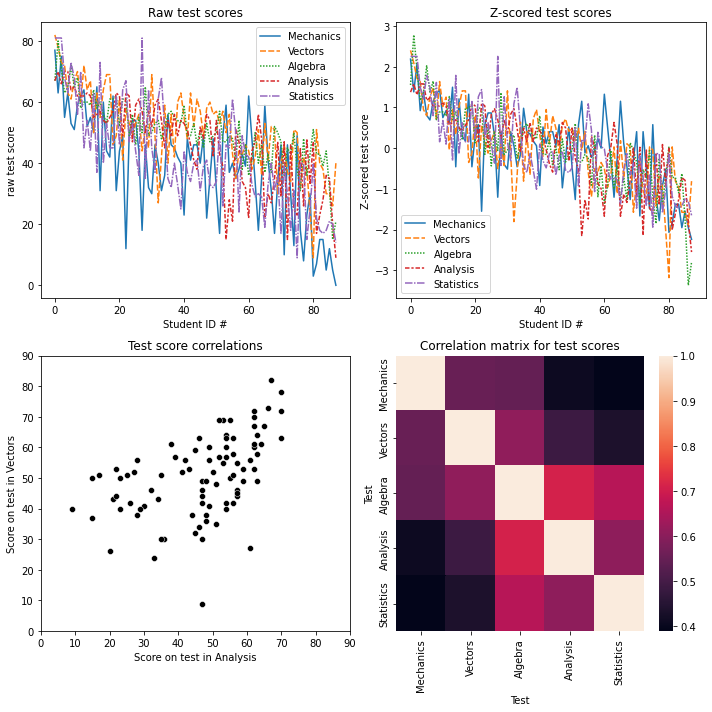

In [3]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

# Plot the raw data to get a sense of the correlations
sns.lineplot(data = data, ax = axes[0, 0])
axes[0, 0].set(title = 'Raw test scores', xlabel = 'Student ID #', ylabel = 'raw test score');

# We can do even better by first z-scoring the data
# Note that scipy.stats.zscore operates on columns by default, so we are essentially
# normalizing each students score within each test
Z = scipy.stats.zscore(data)

sns.lineplot(data = Z, ax = axes[0, 1])
axes[0, 1].set(title = 'Z-scored test scores', xlabel = 'Student ID #', ylabel = 'Z-scored test score');
axes[0, 1].legend(test_names)

# How well correlated are students on two randomly chosen tests?

# Pick 2 random tests, but not the same one twice
testX, testY = np.random.choice(test_names, size = (2,), replace = False)

sns.scatterplot(data = data, x = testX, y = testY, color = 'k', ax = axes[1, 0])
axes[1, 0].set(xlim = [0, 90], ylim = [0, 90], xlabel = f'Score on test in {testX}',
               ylabel = f'Score on test in {testY}', title = 'Test score correlations')

# Look at the entire correlation matrix
rho_cols = data.corr()

sns.heatmap(rho_cols, ax = axes[1, 1])
axes[1, 1].set(xlabel = 'Test', ylabel = 'Test', 
               title = 'Correlation matrix for test scores');
               
plt.tight_layout()

**QUESTION (Q1):** Which two tests are most highly correlated with one another?


Ans: Analysis & algebra

# PCA to capture sources of maximal variance

We first note that the test scores are correlated: a student who did well
on one test also tended to do well on the others. In the limit, each
student (x) could be captured by a single number, Q, that would
completely describe her performance: x_i = Q_i * v

We could think of Q as each student's "scientific IQ". In the language of
linear algebra (PCA), v is the eigenvector of the covariance matrix (the
first principle component) and Q_i is the distance along the line defined
by the eigenvector for each student. The eigenvalues reflect the amount
of variance explained by each eigenvector, so the ratio of the 1st
eigenvalue to the sum of all the eigenvalues gives the proportion of
variance explained by the first principle component. Thus it tells us how
much of the variability among the different students can be explained by
a single number, the scientific IQ.

Calculate the observed value for the variance explained by the first
principle component:

`pca.components_`: the coefficients for the principal components; 1st PC is column 1, etc.

`scores`: the representations of the data in the principal component space

`pca.explained_variance_`: the eigenvalues of the covariance matrix: the variance explained by each PC


In [4]:
pca = sklearn.decomposition.PCA()

scores = pca.fit_transform(data)

TODO: Calculate the proportion of variance explained by the 1st PC and
store it in `th_hat`


In [5]:
th_hat = pca.explained_variance_[0] / pca.explained_variance_.sum()
print(th_hat)

0.6191150384212911


**QUESTION (Q2):** What is the proportion of variance explained by the first
principle component?


Ans: 0.6191

# Bootstrap to calculate standard error of our measure.

How precise is our value for proportion of variance explained? There is
no simple formula for this, like there is for the standard error of the
mean, but we can do it with the bootstrap by taking random samples of the
rows, with replacement.

TODO: Bootstrap the standard error for `th_hat`' and store the standard
error in `th_SE`

In [6]:
th_boot = np.zeros((n_boot,))
np.random.seed(123)

for k in range(n_boot):

    boot_samp =  data.sample(n = n_students, replace = True) 
    
    bs_pca = sklearn.decomposition.PCA()

    bs_pca.fit(boot_samp)
    th_boot[k] = bs_pca.explained_variance_[0] / bs_pca.explained_variance_.sum()

th_SE = np.std(th_boot)

print(th_SE)

0.048369364512934235


**QUESTION (Q3):** What is your value for the standard error?


Ans:  0.0484

# Histogram of bootstrap replicates


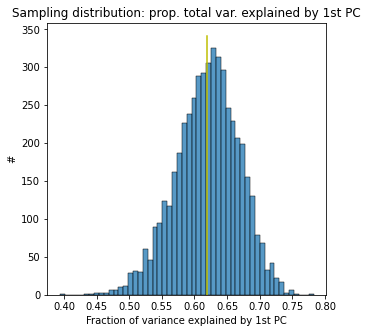

In [7]:
# Make a histogram of the bootstrap replicates and draw a vertical line for
# the actual value (th_hat)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.histplot(data = th_boot, ax = ax)
ax.plot([th_hat, th_hat], ax.get_ylim(), 'y');

ax.set(xlabel = 'Fraction of variance explained by 1st PC',
       ylabel = '#',
       title = 'Sampling distribution: prop. total var. explained by 1st PC');

# Bootstrap of confidence intervals: percentile method

TODO: Use the values in `th_boot` to calculate a 95% Confidence Interval based on the percentile method.


In [8]:
th_boot_sorted = np.sort(th_boot)
i_lo = int(np.floor((my_alpha/2) * n_boot))  # index corresponding to lower bound
i_hi = n_boot - i_lo  # index corresponding to upper bound
th_CI_low = th_boot_sorted[i_lo]
th_CI_hi = th_boot_sorted[i_hi]
print(th_CI_low)

0.519114112381118


**QUESTION (Q4)**: What is your value for the lower bound of the 95% CI?

Ans. 0.5191


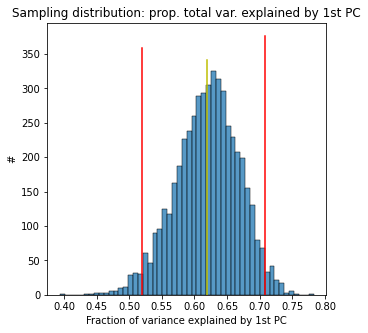

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.histplot(data = th_boot, ax = ax)
ax.plot([th_hat, th_hat], ax.get_ylim(), 'y')

# Draw lines for our 95% CIs
ax.plot([th_CI_low, th_CI_low], ax.get_ylim(), 'r')
ax.plot([th_CI_hi, th_CI_hi], ax.get_ylim(), 'r')

ax.set(xlabel = 'Fraction of variance explained by 1st PC',
       ylabel = '#',
       title = 'Sampling distribution: prop. total var. explained by 1st PC');